#  Sentiment Analysis of IMDB Movie Reviews

For this project, I have used the IMDB movie reviews dataset. It consists of 50,000 movie reviews and 'poistive' or 'negative' sentiment associated with each review.

## Data set

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# change this to the path in google drive where the files are located
%cd /content/drive/MyDrive/TDDE16-Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TDDE16-Project


In [2]:
#Importing all the dependencies which will be required further in the project
import re
import bz2
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en import stop_words
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Cleaning the data
df = (pd.read_csv('IMDB Dataset.csv').drop_duplicates())
print(f'Numbers of samples: {len(df)}')
df.head()

Numbers of samples: 49582


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Preprocessing
def preprocess(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stop_words.STOP_WORDS
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [5]:
# Function to Removes html tags and extra whitespaces.
def clean_text(text):
    text =  " ".join(text.split())
    text = re.sub(r'<.*?>', '', text)
    return text

In [6]:
# #Preprocessing the data
df['review'] = df['review'].apply(lambda x: clean_text(preprocess(x)))

In [7]:
# Converting the target valur to integers
df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == "negative" else 1)
print(df['sentiment'].value_counts())

1    24884
0    24698
Name: sentiment, dtype: int64


#Analysing the data

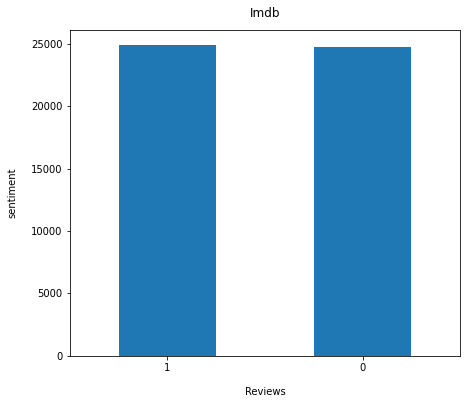

In [8]:
#Plotting data for 2017-18 campaign
df['sentiment'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Reviews", labelpad=14)
plt.ylabel("sentiment", labelpad=14)
plt.title("Imdb", y=1.02);

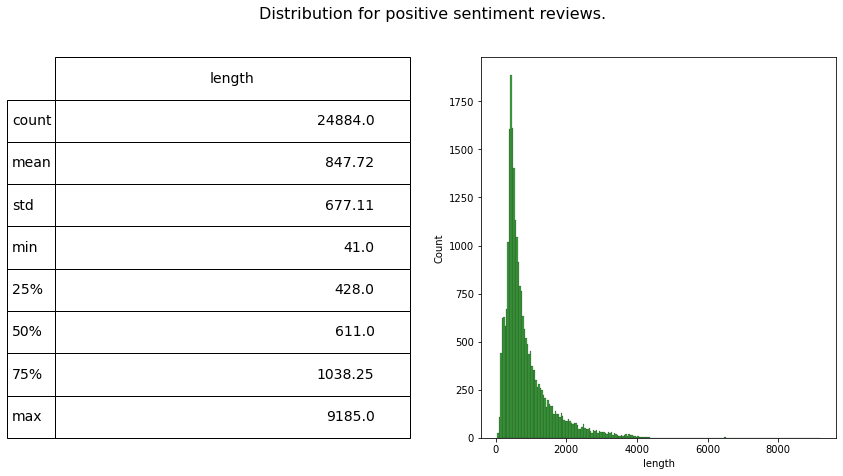

In [9]:
#PLotting the distribution of positive sentiment reviews
fig = plt.figure(figsize=(14,7))
df['length'] = df.review.apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==1]['length'], ax=ax1,color='green')
describe = df.length[df.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution for positive sentiment reviews.', fontsize=16)

plt.show()

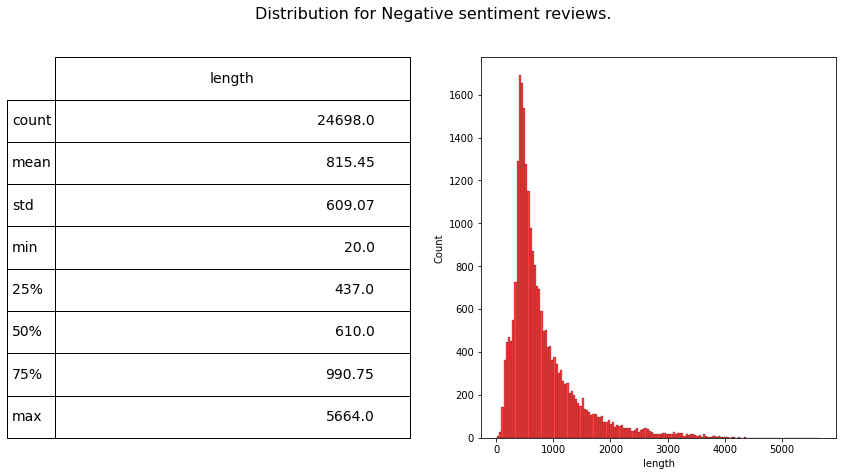

In [10]:
#Plotting the distribution of negative sentiment reviews
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==0]['length'], ax=ax1,color='red')
describe = df.length[df.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution for Negative sentiment reviews.', fontsize=16)

plt.show()

#Creating the Training and Validation dataset

In [11]:
#splitting the complete dataset in test and training dataset:
x_train, x_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.30, random_state=2)

In [12]:
#converting the sentiments (positive and negatives) to 1 and 0. 
y_train = (y_train.replace({'positive': 1, 'negative': 0})).values
y_test = (y_test.replace({'positive': 1, 'negative': 0})).values

#Fitting a Multinomial Naive Bayes model

In [13]:
#Pipeline for fitting a Multinomial Naive Bayes Model
pipe = Pipeline([("vect", TfidfVectorizer()), ('clf', MultinomialNB())])
pipe.fit(x_train, y_train)
pred = pipe.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      7390
           1       0.87      0.84      0.86      7485

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



#Using GridSearch Cross Validation to find optimal parameters for the Multinomial Naive Bayes model.
#Baseline Model

In [14]:
from sklearn.model_selection import GridSearchCV

pipe_cv = Pipeline([("vect", TfidfVectorizer()), ('clf', MultinomialNB())])

parameters = {'vect__binary': [True, False],
              'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__alpha': (1, 0.1)}

CV_grid_search = GridSearchCV(pipe_cv, parameters, cv= 5)
grid_search_fit = CV_grid_search.fit(x_train, y_train)

In [15]:
#Finding the optimal parameters
grid_search_fit.best_params_

{'clf__alpha': 0.1, 'vect__binary': True, 'vect__ngram_range': (1, 2)}

In [16]:
cv_pred = grid_search_fit.predict(x_test)
print(classification_report(y_test, cv_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7390
           1       0.90      0.87      0.88      7485

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



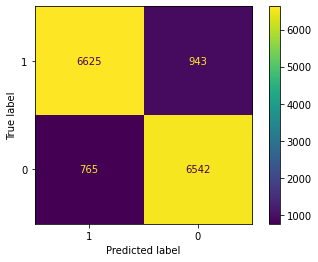

In [17]:
conf_mat = confusion_matrix(cv_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[1,0])
disp.plot()
plt.show()

#Fitting a linear support vector machine (SVM) model

In [18]:
#Pipeline for fitting a linear support vector machine (SVM).
from sklearn.linear_model import SGDClassifier

#SGDClassifier, by default fits a linear support vector machine (SVM).
pipe_sgd = Pipeline([("vect", TfidfVectorizer()), ('clf', SGDClassifier())])

parameters = {'vect__binary': [True, False],
              'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__alpha': (1, 0.1)}

sgd_grid_search = GridSearchCV(pipe_sgd, parameters, cv= 5)
sgd_grid_search_fit = sgd_grid_search.fit(x_train, y_train)

In [19]:
#Finding the optimal parameters
sgd_grid_search_fit.best_params_

{'clf__alpha': 0.1, 'vect__binary': False, 'vect__ngram_range': (1, 1)}

In [20]:
sgd_pred = sgd_grid_search_fit.predict(x_test)
print(classification_report(y_test, cv_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7390
           1       0.90      0.87      0.88      7485

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



# Looking at the word cloud for Positive sentiment reviews

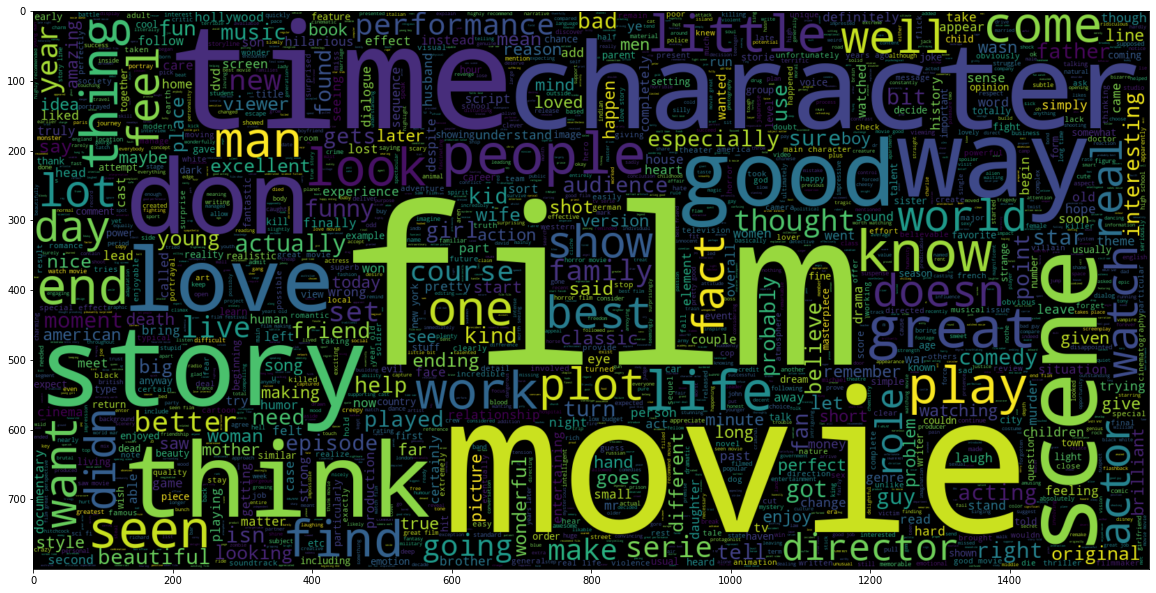

In [21]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

# Looking at the word cloud for Negative sentiment reviews

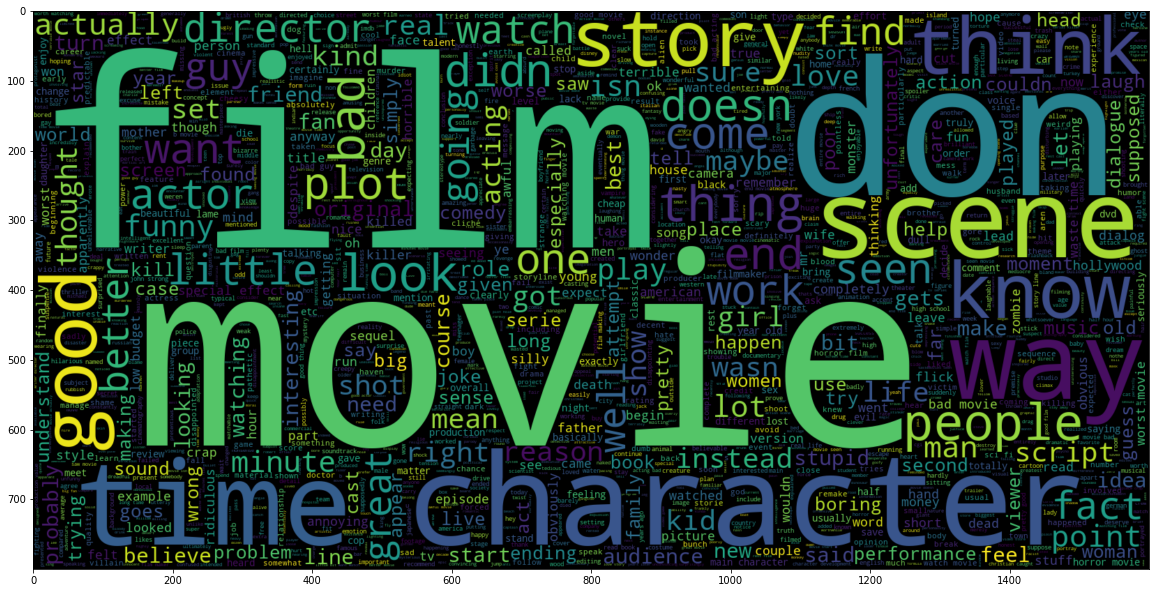

In [22]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In the worcloud for the positive sentiment reviews, words like good, great, funny, nice and excellent are visible. Whereas, in the wordcloud for the negative movie reviews, words like bad and boring are visible.